In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import random

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print(f"x_train {x_train.shape:}, y_train {y_train.shape}")
print(f"x_test {x_test.shape}, y_test {y_test.shape}")

x_train (60000, 28, 28), y_train (60000,)
x_test (10000, 28, 28), y_test (10000,)


In [5]:
dataset_size = 100000
gen_x = []
gen_y = []
for _ in range(dataset_size):
    width, height = 75, 75
    new_img = np.zeros((width, height), dtype='uint8')
    num = random.choice(range(10))

    fonts = [cv2.FONT_HERSHEY_PLAIN, cv2.FONT_HERSHEY_SIMPLEX]
    selected_font = random.choice([0, 1])
    
    size_font1 = np.random.choice([3, 4, 5, 6])
    size_font2 = np.random.choice([1, 2])
    size = size_font1 if selected_font  == 0 else size_font2
    if selected_font == 0:
        rw, rh = random.choice(range(-width//(2 * size), height//(2 * size))), random.choice(range(-width//(2 * size), height//(2 * size)))
    else:
        rw, rh = 0, 0
    pos = (width // 2 - size * 5 + rw, height // 2 + size * 5 + rh)
    boldness_font1 = random.choice([2, 3, 4, 5])
    boldness_font2 = random.choice([5, 6, 7, 8])
    boldness = boldness_font1 if selected_font == 0 else boldness_font2
    _ = cv2.putText(new_img, f'{num}', pos, fonts[selected_font], size, (255, ), boldness)
    random_pad_x = random.choice([0, 1, 2, 3, 4, 5])
    random_pad_y = random.choice([0, 1, 2, 3, 4, 5])
    new_img = cv2.copyMakeBorder(new_img, random_pad_x, random_pad_x, random_pad_y, random_pad_y, cv2.BORDER_CONSTANT, 0)
    if np.random.rand() < 0.5:
        k = random.choice([3, 5])
        op = random.choice([cv2.MORPH_CLOSE, cv2.MORPH_CROSS])
        new_img = cv2.morphologyEx(new_img, op, np.ones((k, k)))
    new_img = cv2.resize(new_img, (28, 28))
    gen_x.append(new_img)
    gen_y.append(num)

gen_x = np.array(gen_x, dtype='float32')
gen_y = np.array(gen_y, dtype='float32')

gen_x_train = gen_x[:50000, ...]
gen_y_train = gen_y[:50000, ...]

gen_x_test = gen_x[50000:, ...]
gen_y_test = gen_y[50000:, ...]

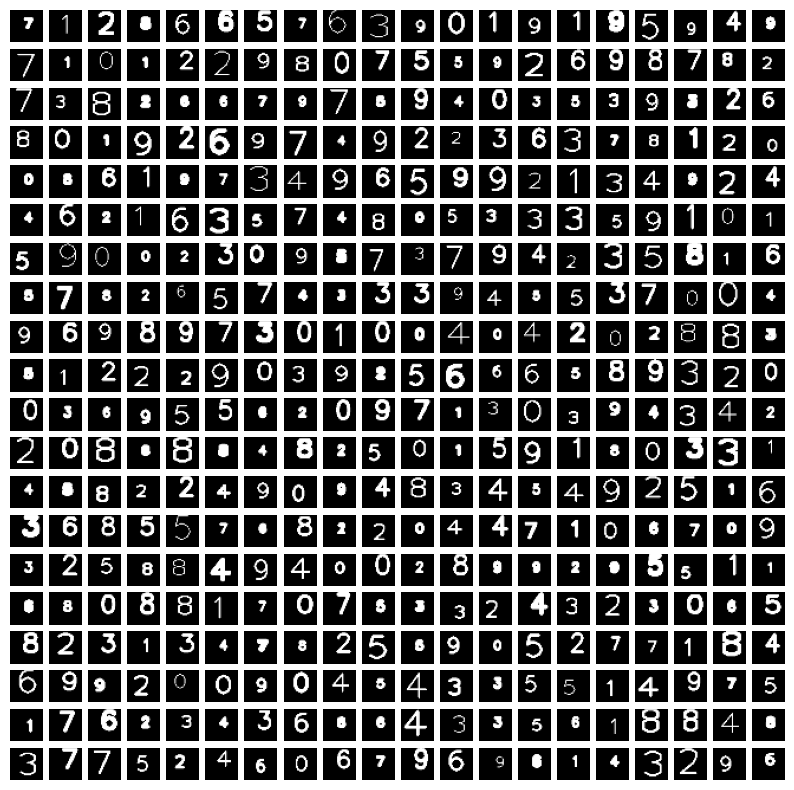

In [9]:
fig = plt.figure(figsize=(10, 10))
for i in range(400):
    ax = plt.subplot(20, 20, i + 1)
    ax.imshow(gen_x_train[i], cmap='gray')
    ax.axis('off')
fig.savefig('./docs/numeric_dataset.jpg', dpi=400)

In [11]:
def create_blob(num_blobs):
    width, height = 75, 75
    new_img = np.zeros((width, height), dtype='uint8')
    for _ in range(num_blobs):
        radius = random.choice(range(1, 6))
        pos = random.choice(range(0, width)), random.choice(range(0, height))
        random_thickness = random.choice([-1, 1, 2, 3])
        _ = cv2.circle(new_img, pos, radius, (255, ), random_thickness)
    new_img = cv2.resize(new_img, (28, 28), interpolation=cv2.INTER_CUBIC)
    return new_img


gen_blob_x = []
gen_blob_y = []

for _ in range(20000):
    num_blobs = random.choice(range(0, 10))
    new_img = create_blob(num_blobs)
    gen_blob_x.append(new_img)
    gen_blob_y.append(10)

gen_blob_x = np.array(gen_blob_x, dtype='float32')
gen_blob_y = np.array(gen_blob_y, dtype='float32')

gen_blob_x_train = gen_blob_x[:10000, ...]
gen_blob_y_train = gen_blob_y[:10000, ...]

gen_blob_x_test = gen_blob_x[10000:, ...]
gen_blob_y_test = gen_blob_y[10000:, ...]

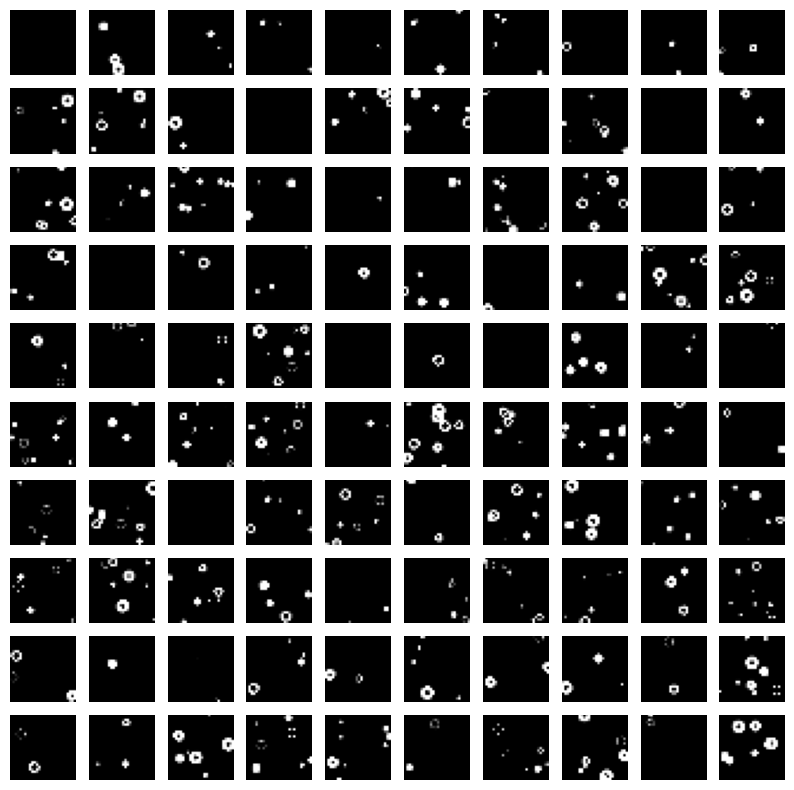

In [13]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    ax.imshow(gen_blob_x_train[i], cmap='gray')
    ax.axis('off')

fig.savefig('./docs/blob_dataset.jpg', dpi=400)

In [8]:
x_train = np.concatenate([gen_x_train, gen_blob_x_train, x_train], axis=0)
y_train = np.concatenate([gen_y_train, gen_blob_y_train, y_train], axis=0)

x_train = np.expand_dims(x_train, -1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.concatenate([gen_x_test, gen_blob_x_test, x_test], axis=0)
y_test = np.concatenate([gen_y_test, gen_blob_y_test, y_test], axis=0)

x_test = np.expand_dims(x_test, -1)
y_test = keras.utils.to_categorical(y_test)

## Create a pipeline

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocessing_inputs(img, label):
    img = tf.cast(img, dtype='float32')
    img = (img / 127.5) - 1
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocessing_inputs, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=True, drop_remainder=True)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocessing_inputs, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=True, drop_remainder=True)
test_ds = test_ds.prefetch(AUTOTUNE)

## Create the model

In [10]:
from keras.layers import Layer, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, Precision, Recall, F1Score
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [11]:
class ConvBlock(Layer):
    def __init__(self, filters, kernel_size=(3, 3), momentum=0.99):
        super(ConvBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.momentum = momentum

        self.conv = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', name='conv')
        self.bn = BatchNormalization(momentum=momentum, name='bn')
        self.act = Activation('relu', name='act')

    def build(self, input_shape):
        inputs = Input(shape=input_shape[1:])
        self.call(inputs)
        super(ConvBlock, self).build(input_shape)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        return x

In [12]:
class ResBlock(Layer):
    def __init__(self, filters, momentum=0.99):
        super(ResBlock, self).__init__()
        self.filters = filters
        self.momentum = momentum

        self.conv_block1 = ConvBlock(filters[0], momentum=momentum)
        self.conv_block2 = ConvBlock(filters[1], momentum=momentum)
        self.skip_connection = Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', name='skip')
        self.conv_block3 = ConvBlock(filters=filters[2], momentum=momentum)
        self.maxpooling = MaxPooling2D(name='max_pooling')

    
    def build(self, input_shape):
        inputs = Input(shape=input_shape[1:])
        self.call(inputs)
        super(ResBlock, self).__init__()
        

    def call(self, inputs):
        x = self.conv_block1(inputs)
        x = self.conv_block2(x)
        skip = self.skip_connection(inputs)
        x = self.conv_block3(x + skip)
        x = self.maxpooling(x)
        return x

In [13]:
class ResNet(Model):
    def __init__(self, num_classes, momentum=0.99):
        super(ResNet, self).__init__()

        self.num_classes = num_classes
        self.momentum = momentum

        self.conv_block = ConvBlock(filters=64, kernel_size=(5, 5), momentum=momentum)
        self.maxpooling = MaxPooling2D(name='maxpooling')

        self.resblock1 = ResBlock(filters=[64, 64, 128], momentum=momentum)
        self.resblock2 = ResBlock(filters=[128, 128, 256], momentum=momentum)
        self.global_avg = GlobalAveragePooling2D(name='global_avg')
        self.dropout = Dropout(0.7)
        self.classifier = Dense(num_classes)
        self.act = Activation('softmax', name='act')


    def build(self, input_shape):
        inputs = Input(shape=input_shape[1:])
        self.call(inputs)
        super(ResNet, self).build(input_shape)
    

    def call(self, inputs):
        x = self.conv_block(inputs)
        x = self.maxpooling(x)

        x = self.resblock1(x)
        x = self.resblock2(x)

        x = self.global_avg(x)
        x = self.dropout(x)
        x = self.classifier(x)
        x = self.act(x)
        return x

In [14]:
resnet = ResNet(11, momentum=0.6)
resnet.build(x_train.shape)
resnet.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      (None, 28, 28, 64)        1920      
                                                                 
 maxpooling (MaxPooling2D)   (None, 14, 14, 64)        0         
                                                                 
 res_block (ResBlock)        (None, 7, 7, 128)         152896    
                                                                 
 res_block (ResBlock)        (None, 3, 3, 256)         608896    
                                                                 
 global_avg (GlobalAverageP  (None, 256)               0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                           

In [15]:
def get_learning_scheduler(initial_learning_rate, weight=0.9, min_learning_rate=1e-5):
    def scheduler(epoch):
        return initial_learning_rate * weight ** epoch
    return scheduler

In [16]:
resnet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(name='accuracy'), Precision(), Recall(), F1Score()]
)

lr_scheduler_callback = LearningRateScheduler(get_learning_scheduler(3e-3, 0.9))
check_point_callback = ModelCheckpoint('./check_points/', save_best_only=True, save_weights_only=True)

In [17]:
history = resnet.fit(
    train_ds,
    epochs=40,
    validation_data=test_ds,
    callbacks=[lr_scheduler_callback, check_point_callback]
)

Epoch 1/40


I0000 00:00:1712419515.798475   27007 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 28s 12ms/step - loss: 0.1357 - accuracy: 0.9603 - precision: 0.9747 - recall: 0.9522 - f1_score: 0.9603 - val_loss: 1.1760 - val_accuracy: 0.6959 - val_precision: 0.7729 - val_recall: 0.6595 - val_f1_score: 0.7016 - lr: 0.0030
Epoch 2/40
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0463 - accuracy: 0.9869 - precision: 0.9894 - recall: 0.9850 - f1_score: 0.9869 - val_loss: 0.7601 - val_accuracy: 0.7802 - val_precision: 0.8247 - val_recall: 0.7472 - val_f1_score: 0.7930 - lr: 0.0027
Epoch 3/40
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0349 - accuracy: 0.9902 - precision: 0.9918 - recall: 0.9887 - f1_score: 0.9902 - val_loss: 0.4569 - val_accuracy: 0.8620 - val_precision: 0.9038 - val_recall: 0.8409 - val_f1_score: 0.8663 - lr: 0.0024
Epoch 4/40
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0268 - accuracy: 0.9927 - precision: 0.9939 - recall: 0.9916 - f1_score: 0.9928 - 

## Visualization

In [18]:
def plot(history, ax, key, only_valid=False):
    train_key = 'train_' + key
    valid_key = 'val_' + key
    if not only_valid:
        ax.plot(history.epoch, history.history[key], label=train_key)
    ax.plot(history.epoch, history.history[valid_key], label=valid_key)
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid(c='#ddd')
    ax.legend()

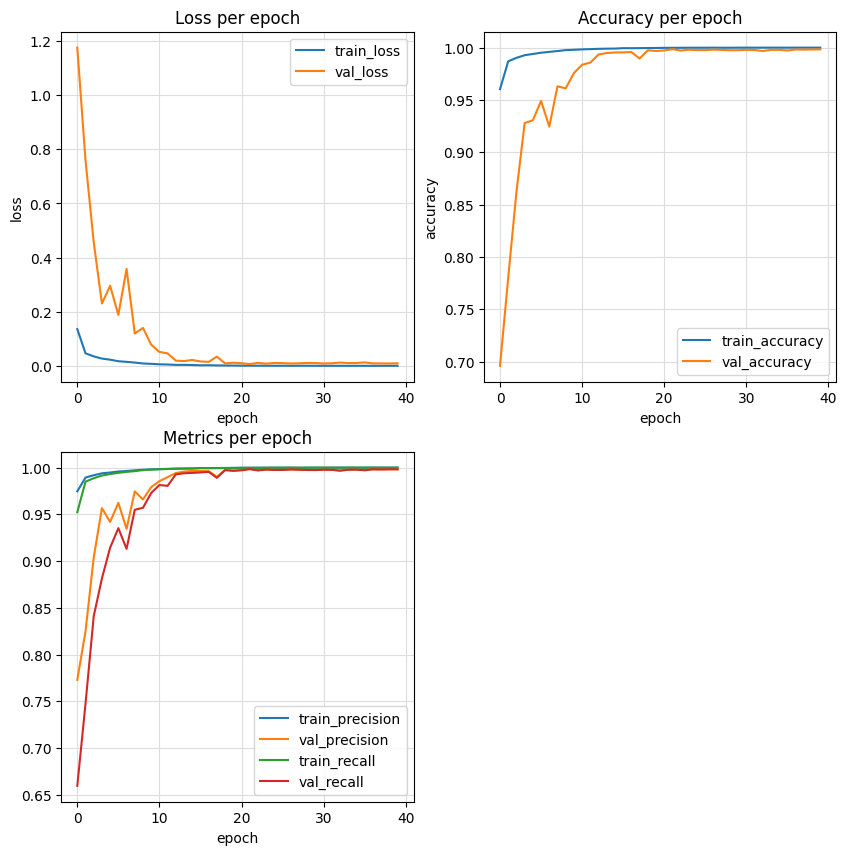

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plot(history, ax, 'loss')

ax = plt.subplot(2, 2, 2)
plot(history, ax, 'accuracy')

ax = plt.subplot(2, 2, 3)
plot(history, ax, 'precision')
plot(history, ax, 'recall')
ax.set_ylabel('')
ax.set_title('Metrics per epoch');

### Confusion Matrix

<Figure size 500x500 with 0 Axes>

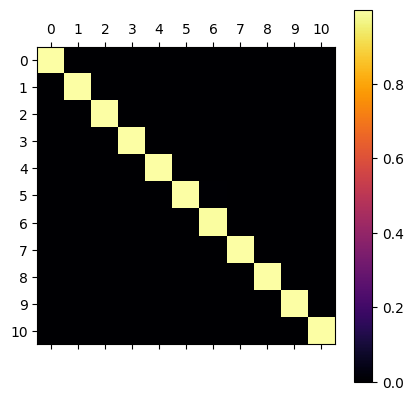

In [20]:
conf_matrix = np.zeros((11, 11), dtype='int32')
y_true = np.array([np.argmax(x, axis=-1) for img, x in test_ds]).reshape((-1, ))
y_pred = resnet.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred, axis=-1)

for i in range(len(y_true)):
    predicted = y_pred[i]
    true_label = y_true[i]
    conf_matrix[predicted, true_label] += 1

conf_matrix = conf_matrix.astype('float32') / np.sum(conf_matrix, axis=0)

plt.figure(figsize=(5, 5));
plt.matshow(conf_matrix, cmap='inferno');
plt.colorbar();
plt.xticks([x for x in range(11)]);
plt.yticks([x for x in range(11)]);

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6031
           1       1.00      1.00      1.00      6200
           2       1.00      1.00      1.00      5967
           3       1.00      1.00      1.00      5983
           4       1.00      1.00      1.00      6006
           5       0.99      1.00      1.00      6026
           6       1.00      0.99      1.00      5815
           7       1.00      1.00      1.00      5966
           8       1.00      1.00      1.00      5848
           9       1.00      1.00      1.00      6110
          10       1.00      1.00      1.00     10000

    accuracy                           1.00     69952
   macro avg       1.00      1.00      1.00     69952
weighted avg       1.00      1.00      1.00     69952



## Saving the model

In [22]:
resnet_pred = keras.Sequential([
    keras.layers.Lambda(lambda x: (x / 127.5) - 1),
    resnet
])

resnet_pred.build(x_train.shape)
resnet_pred.summary()

resnet_pred.save('./models/resnet.tf')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (120000, 28, 28, 1)       0         
                                                                 
 res_net (ResNet)            (120000, 11)              766539    
                                                                 
Total params: 766539 (2.92 MB)
Trainable params: 764875 (2.92 MB)
Non-trainable params: 1664 (6.50 KB)
_________________________________________________________________
INFO:tensorflow:Assets written to: ./models/resnet.tf/assets


INFO:tensorflow:Assets written to: ./models/resnet.tf/assets


In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/resnet.tf')
tflite_model = converter.convert()
with open('./models/resnet.tflite', 'wb') as file:
    file.write(tflite_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 23, Total Ops 45, % non-converted = 51.11 %
 * 23 ARITH ops

- arith.constant:   23 occurrences  (f32: 22, i32: 1)



  (f32: 2)
  (f32: 9)
  (f32: 1)
  (f32: 3)
  (f32: 1)
  (f32: 1)
  (f32: 1)
  (f32: 1)
